# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

# For visualisation  
import matplotlib.pyplot as plt
%matplotlib inline

# Tf layers
import tensorflow as tf
from tensorflow.keras import layers

# For checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

We set the random seed so that the results don't vary drastically.

In [1]:
#Importing required libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

batch_size = 8 
num_epochs = 30 # choose the number of epochs

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
#len([i for i in range(1, 31, 2)]) # To determine the number of frames

In [5]:
# Taking every alternative image to reduce runtime
img_idx = [i for i in range(1, 31, 2)]
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size) 
    
    x = len(img_idx) # number of frames
    y,z = 120,120 # The size of the images. 
    resize_and_rescale = tf.keras.Sequential([  
      layers.experimental.preprocessing.Resizing(y,z), # Resizing the image.
      layers.experimental.preprocessing.Rescaling(1./255) # Normalization of the image.
    ])
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                   # As there are two image shapes(360*360, 120*160), this will throw an error while passing as input to the NN. 
                    # As the decided shape is 120*120(small&square advantage, hence avoiding skewness and reducing the training time).
                    
                    # center crop the 120*160 into 120*120, whilst leaving the 360*360 as such.
                    if image.shape == (120, 160, 3):
                        image = image[:,20:140,:] # Cropping in action 
                        
                    image = resize_and_rescale(image) # Resizing and normalizing the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #feeding the image channel-wise
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding the batches
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # Creating a single batch for the leftover folders
        remaining_folders = len(t)%batch_size # Number of leftover folders.
        
        # The same process as done before, refer to the comments above
        batch_data2 = np.zeros((remaining_folders,x,y,z,3)) 
        batch_labels2 = np.zeros((remaining_folders,5)) 
        for folder2 in range(remaining_folders):
            imgs2 = os.listdir(source_path+'/'+t[folder2 + (batch*batch_size)].split(';')[0]) 
            for idx2,item2 in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image2 = imread(source_path+'/'+ t[folder2 + (batch*batch_size)].strip().split(';')[0]+'/'+imgs2[item2]).astype(np.float32)

                
                # center crop the image to get 120 x 120
                if image2.shape == (120, 160, 3):
                    image2 = image[:,20:140,:]
                
                image2 = resize_and_rescale(image2)
                    
                batch_data2[folder2,idx2,:,:,0] = image2[:,:,0] 
                batch_data2[folder2,idx2,:,:,1] = image2[:,:,1] #feeding the image channel-wise
                batch_data2[folder2,idx2,:,:,2] = image2[:,:,2] 
                    #plt.imshow(batch_data[folder,idx,:,:,:].astype("uint8")) # for testing
                    
                    
                batch_labels2[folder2, int(t[folder2 + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding
        yield batch_data2, batch_labels2 # Yield for the remaining batch

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
# Code given by Upgrad.
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)
print ('batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
batch size = 8


# Data preparation 

In [40]:
#Generate data yield from the data folder

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [41]:
#creating model name, checkpoint & storing

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [42]:
# steps_per_epoch, validation_steps

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [43]:
# required common variables

FRAMES = len(img_idx) # number of frames
DIMENSION = 120 # width & height of image
CLASSES = 5 # number of classes
CHANNELS = 3 # number of channels in RGB image

# Tranfer Learning & GRU - Final Model after all experiments
## All experiments are kept after this model & discussed in the writeup doc 

In [44]:
# Transfer Learning - Mobile net - Basically used for image recognition
# Here, we use mobile net to extract features
# we use 'include_top=False' to customise the input size


# Model referred from - https://keras.io/api/applications/mobilenet/

def get_mobilenet(shape=(DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    
    # 9 layers to train
    # remaining layer to use pre-learned model from Mobilenet
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [46]:
# Transfer learning + GRU

def tl_gru(shape=(FRAMES, DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    # Create our convnet with (120, 120, 3) input shape
    convnet = get_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, we use GRU because it's faster when compared to LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [47]:
# (15, 120, 120, 3, 5)
# 15 frames, 120 width, 120 height, 3 channels, 5 clasees

#Build final model
INSHAPE=(FRAMES,) + (DIMENSION, DIMENSION) + (CHANNELS,)
model = tl_gru(INSHAPE, CLASSES)

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [48]:
#fitting model with 30 epochs

history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6412 - categorical_accuracy: 0.1961Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-08-3117_41_45.490473/model-00001-1.64119-0.19608-1.55675-0.39000.h5
83/83 [==============================] - 60s 728ms/step - loss: 1.6412 - categorical_accuracy: 0.1961 - val_loss: 1.5568 - val_categorical_accuracy: 0.3900
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5904 - categorical_accuracy: 0.2685
Epoch 00002: saving model to model_init_2021-08-3117_41_45.490473/model-00002-1.59039-0.26848-1.49448-0.46000.h5
83/83 [==============================] - 61s 736ms/step - loss: 1.5904 - categorical_accuracy: 0.2685 - val_loss: 1.4945 - val_categorical_accuracy: 0.4600
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.5234 - categorical_accuracy: 0.3348
Epoch 00003: s

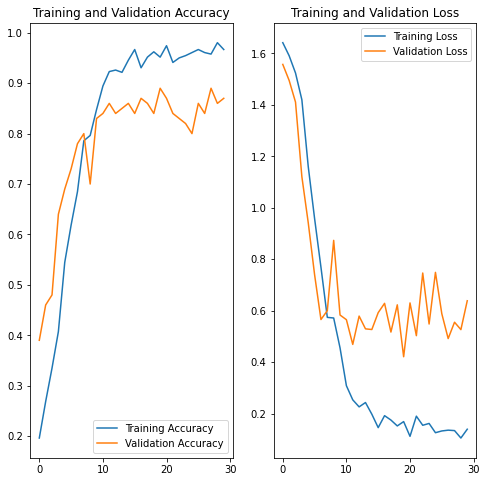

In [49]:
# Visualising Training & Validation accuracy for 30 epochs
# Visualising Training & Validation loss for 30 epochs

acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model accuracy is converging well
## So, we choose this model because this performed better than all the below experiments

In [53]:
# For downloading h5 files
# !tar chvfz take1.tar.gz *

Gesture_Recognition_TL_GRU.ipynb
TLearning_GRU_50epochs.ipynb
model_init_2021-08-3117_41_45.490473/
model_init_2021-08-3117_41_45.490473/model-00001-1.65743-0.21870-1.61366-0.16000.h5
model_init_2021-08-3117_41_45.490473/model-00002-1.62369-0.22172-1.61700-0.23000.h5
model_init_2021-08-3117_41_45.490473/model-00003-1.63835-0.19759-1.60737-0.16000.h5
model_init_2021-08-3117_41_45.490473/model-00004-1.61502-0.21870-1.60922-0.15000.h5
model_init_2021-08-3117_41_45.490473/model-00005-1.61855-0.20664-1.60200-0.23000.h5
model_init_2021-08-3117_41_45.490473/model-00006-1.60774-0.22775-1.56183-0.31000.h5
model_init_2021-08-3117_41_45.490473/model-00007-1.59931-0.23831-1.56980-0.25000.h5
model_init_2021-08-3117_41_45.490473/model-00008-1.57125-0.24133-1.50008-0.29000.h5
model_init_2021-08-3117_41_45.490473/model-00009-1.51441-0.29713-1.52314-0.28000.h5
model_init_2021-08-3117_41_45.490473/model-00010-1.45294-0.31071-1.59471-0.17000.h5
model_init_2021-08-3117_41_45.490473/model-00011-1.37731-0.3

# Below models are used for experimental purposes
# To know more about the experimentation, Refer to the writeup document

## Model1: Simple Conv3D

In [7]:
# Generating Data again

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [8]:
# model name, checkpoint

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [9]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D


#write your model here
num_classes = 5
#@title Trying to build my own model, based on the requiremnet.
my_model_v1= Sequential() # simple model

# 1st layer
# conv3d layer
my_model_v1.add(layers.Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same',strides=1, input_shape=(len(img_idx), 120, 120, 3)))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,2),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
#my_model_v1.add(layers.Dropout(0.4)) # Performs decreased , so remove

# Fully connected layer
# For now lets flatten and use the softmax 
my_model_v1.add(layers.Flatten())
# Summa oru layer
#my_model_v1.add(Dense(10, activation='relu'))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.2))
# Dense(...)... is the output space shape
my_model_v1.add(layers.Dense(num_classes,activation='softmax'))

In [23]:
optimiser ='adam' # Starting with a complex converging optimizer
my_model_v1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (my_model_v1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 128) 10496     
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 128) 512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 120, 120, 64)  221248    
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 64)  256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 14, 119, 119, 64)  0         
_________________________________________________________________
flatten (Flatten)            (None, 12688256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 12688256)          0

In [12]:
# Training the model (30,adam,8-batch_size)
history = my_model_v1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)#,use_multiprocessing=True)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - 117s 1s/step - loss: 2370.4622 - categorical_accuracy: 0.4208 - val_loss: 1604.9407 - val_categorical_accuracy: 0.3900
Epoch 2/20
83/83 [==============================] - 111s 1s/step - loss: 1249.4274 - categorical_accuracy: 0.6410 - val_loss: 1751.9441 - val_categorical_accuracy: 0.4100
Epoch 3/20
83/83 [==============================] - 108s 1s/step - loss: 750.6405 - categorical_accuracy: 0.7451 - val_loss: 1888.9072 - val_categorical_accuracy: 0.4000
Epoch 4/20
83/83 [==============================] - 108s 1s/step - loss: 386.7444 - categorical_accuracy: 0.8643 - val_loss: 1400.9098 - val_categorical_accuracy: 0.5400
Epoch 5/20
83/83 [==============================] - 107s 1s/step - loss: 376.9378 - categorical_accuracy: 0.8869 - val_loss: 2398.4670 - val_categorical_accuracy: 0.5700
Epoch 6/20
83/83 [==============================] - 106s 1s/step - loss: 240.3889 

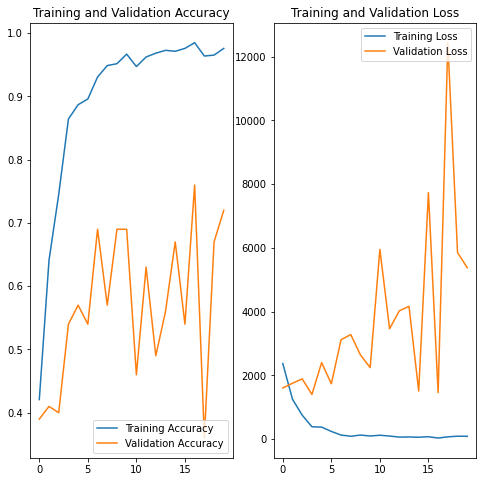

In [13]:
# Visualising Training & Validation accuracy for 30 epochs
# Visualising Training & Validation loss for 30 epochs

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model started to overfit & validation loss started increasing. This is quite expected when we use a simple Conv3D model.This is done to test the generator function & the memory consumption for the given batch size and the number of frames

## Model2: Conv3D with more layers 
### Model2.1: Adam

**Data preparation**

In [10]:
#Generating data

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Model**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# More dropout layers
# Increase filter size along temporal
# Added more layers, to make a complex CNN

num_classes = 5
#@title Trying to build my own model, based on the requiremnet.
my_model_v1= Sequential() # simple model

# 1st layer
# conv3d layer
my_model_v1.add(layers.Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same',strides=1, input_shape=(len(img_idx), 120, 120, 3)))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=64,kernel_size=(3,3,5),activation='relu',padding='same',strides=2))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# 2nd Layer
my_model_v1.add(layers.Conv3D(filters=32,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=32,kernel_size=(3,3,5),activation='relu',padding='same',strides=2))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# 3rd Layer
my_model_v1.add(layers.Conv3D(filters=16,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=16,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# Fully connected layer
# For now lets flatten and use the softmax 
my_model_v1.add(layers.Flatten())
# Summa oru layer
#my_model_v1.add(Dense(10, activation='relu'))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.2))
# Dense(...)... is the output space shape
my_model_v1.add(layers.Dense(num_classes,activation='softmax'))

In [14]:
optimiser ='adam' # Starting with a complex converging optimizer
my_model_v1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (my_model_v1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 128) 10496     
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 120, 128) 512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 64)     368704    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 64)     256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 59, 56, 64)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 59, 56, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 59, 56, 32)     9

In [15]:
# Training the model (30,adam,8-batch_size)
history = my_model_v1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)#,use_multiprocessing=True)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 7.0911 - categorical_accuracy: 0.3529Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-09-0107_30_39.915473/model-00001-7.09107-0.35294-24.77857-0.15000.h5
83/83 [==============================] - 80s 965ms/step - loss: 7.0911 - categorical_accuracy: 0.3529 - val_loss: 24.7786 - val_categorical_accuracy: 0.1500
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 4.6917 - categorical_accuracy: 0.4510
Epoch 00002: saving model to model_init_2021-09-0107_30_39.915473/model-00002-4.69170-0.45098-10.82074-0.20000.h5
83/83 [==============================] - 77s 928ms/step - loss: 4.6917 - categorical_accuracy: 0.4510 - val_loss: 10.8207 - val_categorical_accuracy: 0.2000
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 4.2891 - categorical_accuracy: 0.4887
Epoch 0000

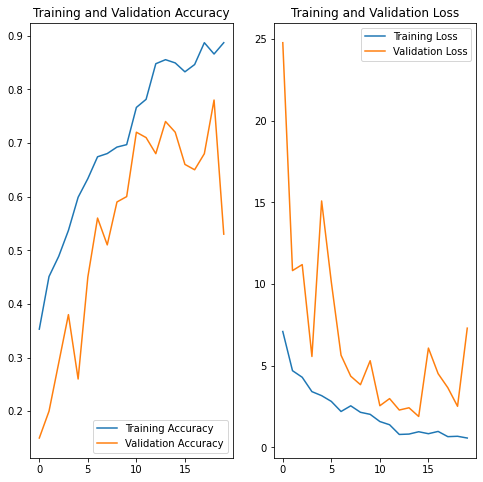

In [16]:
# Visualising Training & Validation accuracy for 30 epochs
# Visualising Training & Validation loss for 30 epochs

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### After adding more layer, validation loss & overfitting reduced significantly

### Model2.2: SGD (optimizer)

**Data preparation**

In [18]:
#Generating data

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Model**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


# More dropout layers
# Increase filter size along temporal
# Added more layers, to make a complex CNN

num_classes = 5
#@title Trying to build my own model, based on the requiremnet.
my_model_v1= Sequential() # simple model

# 1st layer
# conv3d layer
my_model_v1.add(layers.Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same',strides=1, input_shape=(len(img_idx), 120, 120, 3)))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=64,kernel_size=(3,3,5),activation='relu',padding='same',strides=2))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# 2nd Layer
my_model_v1.add(layers.Conv3D(filters=32,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=32,kernel_size=(3,3,5),activation='relu',padding='same',strides=2))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# 3rd Layer
my_model_v1.add(layers.Conv3D(filters=16,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# A similar(lesser filters though) conv3d network
my_model_v1.add(layers.Conv3D(filters=16,kernel_size=(3,3,5),activation='relu',padding='same',strides=1))
# Batch normalisation for speed
my_model_v1.add(layers.BatchNormalization())
# Max pooling thses 2 features
my_model_v1.add(layers.MaxPooling3D(pool_size=(2,2,5),strides=1))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.4))

# Fully connected layer
# For now lets flatten and use the softmax 
my_model_v1.add(layers.Flatten())
# Summa oru layer
#my_model_v1.add(Dense(10, activation='relu'))
# Add a drop out to increase compleity of the network, what this does is pick a random weight and set it to 0# Prevent overfitting
my_model_v1.add(layers.Dropout(0.2))
# Dense(...)... is the output space shape
my_model_v1.add(layers.Dense(num_classes,activation='softmax'))

In [22]:
optimiser ='sgd' # Starting with a complex converging optimizer
my_model_v1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (my_model_v1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 120, 120, 128) 10496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 120, 120, 128) 512       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 8, 60, 60, 64)     368704    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 64)     256       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 59, 56, 64)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 59, 56, 64)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 59, 56, 32)    

In [23]:
# Training the model (30,adam,8-batch_size)
history = my_model_v1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)#,use_multiprocessing=True)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 11.1407 - categorical_accuracy: 0.3680Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-09-0107_30_39.915473/model-00001-11.14069-0.36802-4.57634-0.21000.h5
83/83 [==============================] - 74s 896ms/step - loss: 11.1407 - categorical_accuracy: 0.3680 - val_loss: 4.5763 - val_categorical_accuracy: 0.2100
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.2982 - categorical_accuracy: 0.4947
Epoch 00002: saving model to model_init_2021-09-0107_30_39.915473/model-00002-1.29818-0.49472-2.51254-0.32000.h5
83/83 [==============================] - 75s 899ms/step - loss: 1.2982 - categorical_accuracy: 0.4947 - val_loss: 2.5125 - val_categorical_accuracy: 0.3200
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.0603 - categorical_accuracy: 0.5988
Epoch 00003

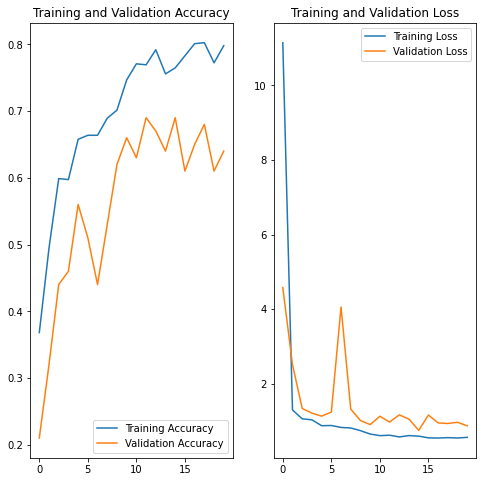

In [24]:
# Visualising Training & Validation accuracy for 30 epochs
# Visualising Training & Validation loss for 30 epochs

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Changing the Optimiser from 'sgd' to 'adam' improved the model metrics

## Model3: Conv2D + GRU

**Data preparation**

In [7]:
#Generating data

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [8]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [9]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:
FRAMES = len(img_idx) # number of frames
DIMENSION = 120 # width & height of image
CLASSES = 5 # number of classes
CHANNELS = 3 # number of channels in RGB image

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D

#Building convolution network to extract features from the image
#input shape (120, 120, 3)
def build_convolution_net(shape=(DIMENSION, DIMENSION, CHANNELS)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape, padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    model.add(Dropout(.2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    model.add(Dropout(.2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool2D())
    return model

In [12]:
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout

# Convultion layer to extract features from image & GRU to process time sequence
# Input (15, 120, 120, 3)
def conv_gru(shape=(FRAMES, DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    # Create our convnet with (120, 120, 3) input shape
    convnet = build_convolution_net(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (15, 120, 120, 3) shape
    # Time Distribution to bridge time sequence data with GRU
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, we use GRU because it's faster than LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [13]:
# (15, 120, 120, 3, 5)
# 15 frames, 120 width, 120 height, 3 channels, 5 clasees

INSHAPE=(FRAMES,) + (DIMENSION, DIMENSION) + (CHANNELS,)
model = conv_gru(INSHAPE, CLASSES)

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 512)           4689216   
_________________________________________________________________
gru (GRU)                    (None, 64)                110976    
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6574 - categorical_accuracy: 0.2187Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-08-3117_41_45.490473/model-00001-1.65743-0.21870-1.61366-0.16000.h5
83/83 [==============================] - 90s 1s/step - loss: 1.6574 - categorical_accuracy: 0.2187 - val_loss: 1.6137 - val_categorical_accuracy: 0.1600
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.6237 - categorical_accuracy: 0.2217
Epoch 00002: saving model to model_init_2021-08-3117_41_45.490473/model-00002-1.62369-0.22172-1.61700-0.23000.h5
83/83 [==============================] - 74s 886ms/step - loss: 1.6237 - categorical_accuracy: 0.2217 - val_loss: 1.6170 - val_categorical_accuracy: 0.2300
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.6384 - categorical_accuracy: 0.1976
Epoch 00003: savi

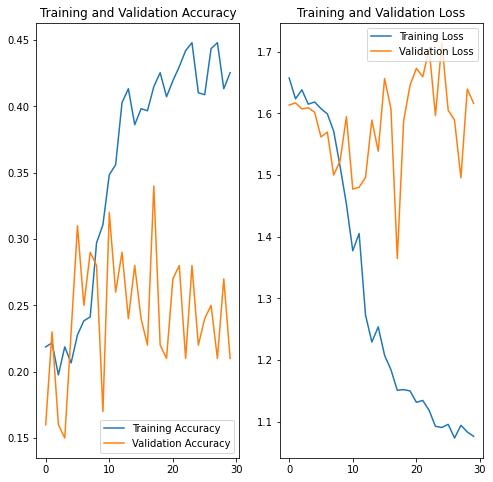

In [65]:
# Visualising Training & Validation accuracy for 30 epochs
# Visualising Training & Validation loss for 30 epochs

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model started to overfit
#### Validation categorical accuracy value is constant
#### Validation loss started increasing

# Transfer Learning + GRU
## No center crop - to see if there is any data loss

In [54]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

batch_size = 8 
num_epochs = 30 # choose the number of epochs

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [55]:
#len([i for i in range(1, 31, 2)]) # To determine the number of frames

In [56]:
# Taking every alternative image to reduce runtime
img_idx = [i for i in range(1, 31, 2)]
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

 
    
    x = len(img_idx) # number of frames
    y,z = 120,120 # The size of the images. 
    resize_and_rescale = tf.keras.Sequential([  
      layers.experimental.preprocessing.Resizing(y,z), # Resizing the image.
      layers.experimental.preprocessing.Rescaling(1./255) # Normalization of the image.
    ])
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                   # As there are two image shapes(360*360, 120*160), this will throw an error while passing as input to the NN. 
                    # As the decided shape is 120*120(small&square advantage, hence avoiding skewness and reducing the training time).
                    
                    # center crop the 120*160 into 120*120, whilst leaving the 360*360 as such.
                    # if image.shape == (120, 160, 3):
                    #    image = image[:,20:140,:] # Cropping in action 
                        
                    image = resize_and_rescale(image) # Resizing and normalizing the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #feeding the image channel-wise
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding the batches
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # Creating a single batch for the leftover folders
        remaining_folders = len(t)%batch_size # Number of leftover folders.
        
        # The same process as done before, refer to the comments above
        batch_data2 = np.zeros((remaining_folders,x,y,z,3)) 
        batch_labels2 = np.zeros((remaining_folders,5)) 
        for folder2 in range(remaining_folders):
            imgs2 = os.listdir(source_path+'/'+t[folder2 + (batch*batch_size)].split(';')[0]) 
            for idx2,item2 in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image2 = imread(source_path+'/'+ t[folder2 + (batch*batch_size)].strip().split(';')[0]+'/'+imgs2[item2]).astype(np.float32)

                
                # center crop the image to get 120 x 120
                # if image2.shape == (120, 160, 3):
                #    image2 = image[:,20:140,:]
                
                image2 = resize_and_rescale(image2)
                    
                batch_data2[folder2,idx2,:,:,0] = image2[:,:,0] #normalise and feed in the image
                batch_data2[folder2,idx2,:,:,1] = image2[:,:,1] #normalise and feed in the image
                batch_data2[folder2,idx2,:,:,2] = image2[:,:,2] #normalise and feed in the image
                    #plt.imshow(batch_data[folder,idx,:,:,:].astype("uint8")) # for testing
                    
                    
                batch_labels2[folder2, int(t[folder2 + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding
        #print('inga than issue') # For testing
        yield batch_data2, batch_labels2 # Yield for the remaining batch

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [57]:
# Code given by Upgrad.
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)
print ('batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
batch size = 8


In [58]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [59]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [60]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [61]:
FRAMES = len(img_idx) # number of frames
DIMENSION = 120 # width & height of image
CLASSES = 5 # number of classes
CHANNELS = 3 # number of channels in RGB image

In [62]:
# Transfer Learning - Mobile net - Basically used for image recognition
# Here, we use mobile net to extract features
# we use 'include_top=False' to customise the input size

def get_mobilenet(shape=(DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    
    # 9 layers to train
    # remaining layer to use pre-learned model from Mobilenet
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [63]:
def tl_gru(shape=(FRAMES, DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    # Create our convnet with (112, 112, 3) input shape
    convnet = get_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [64]:
# (15, 120, 120, 3, 5)
# 15 frames, 120 width, 120 height, 3 channels, 5 clasees

INSHAPE=(FRAMES,) + (DIMENSION, DIMENSION) + (CHANNELS,)
model = tl_gru(INSHAPE, CLASSES)

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [66]:
history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6571 - categorical_accuracy: 0.1810Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-08-3119_20_22.561399/model-00001-1.65712-0.18100-1.59340-0.27000.h5
83/83 [==============================] - 67s 806ms/step - loss: 1.6571 - categorical_accuracy: 0.1810 - val_loss: 1.5934 - val_categorical_accuracy: 0.2700
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.6054 - categorical_accuracy: 0.2202
Epoch 00002: saving model to model_init_2021-08-3119_20_22.561399/model-00002-1.60542-0.22021-1.60188-0.20000.h5
83/83 [==============================] - 66s 797ms/step - loss: 1.6054 - categorical_accuracy: 0.2202 - val_loss: 1.6019 - val_categorical_accuracy: 0.2000
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.5979 - categorical_accuracy: 0.2323
Epoch 00003: s

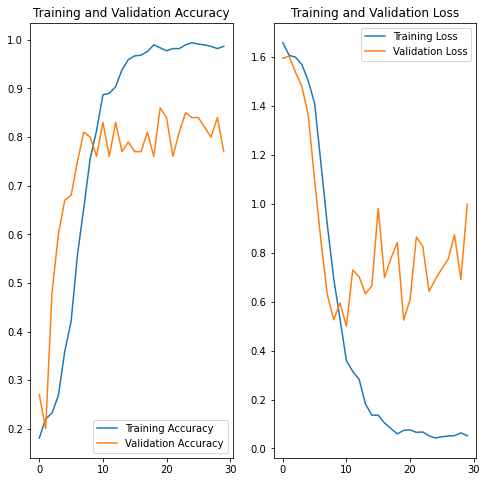

In [67]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Validation loss starts diverging instead of converging

# Transfer Learning + GRU - No crop - Reduce dropout

In [68]:
#Generating dataset

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [69]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [70]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [71]:
FRAMES = len(img_idx) # number of frames
DIMENSION = 120 # width & height of image
CLASSES = 5 # number of classes
CHANNELS = 3 # number of channels in RGB image

In [72]:
# Transfer Learning - Mobile net - Basically used for image recognition
# Here, we use mobile net to extract features
# we use 'include_top=False' to customise the input size

def get_mobilenet(shape=(DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    
    # 9 layers to train
    # remaining layer to use pre-learned model from Mobilenet
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [73]:
def tl_gru(shape=(FRAMES, DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    # Create our convnet with (112, 112, 3) input shape
    convnet = get_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [74]:
# (15, 120, 120, 3, 5)
# 15 frames, 120 width, 120 height, 3 channels, 5 clasees

INSHAPE=(FRAMES,) + (DIMENSION, DIMENSION) + (CHANNELS,)
model = tl_gru(INSHAPE, CLASSES)

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)             

In [ ]:
history3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.2398Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-08-3119_20_22.561399/model-00001-1.60946-0.23982-1.55180-0.37000.h5
83/83 [==============================] - 65s 788ms/step - loss: 1.6095 - categorical_accuracy: 0.2398 - val_loss: 1.5518 - val_categorical_accuracy: 0.3700
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5366 - categorical_accuracy: 0.3575
Epoch 00002: saving model to model_init_2021-08-3119_20_22.561399/model-00002-1.53659-0.35747-1.44285-0.41000.h5
83/83 [==============================] - 65s 782ms/step - loss: 1.5366 - categorical_accuracy: 0.3575 - val_loss: 1.4428 - val_categorical_accuracy: 0.4100
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.3786 - categorical_accuracy: 0.4540
Epoch 00003: s

### Model started Overfitting

# Changing dropout - TL + GRU

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

batch_size = 8 
num_epochs = 30 # choose the number of epochs

#experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
#len([i for i in range(1, 31, 2)]) # To determine the number of frames

In [7]:
# Taking every alternative image to reduce runtime
img_idx = [i for i in range(1, 31, 2)]
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

 
    
    x = len(img_idx) # number of frames
    y,z = 120,120 # The size of the images. 
    resize_and_rescale = tf.keras.Sequential([  
      layers.experimental.preprocessing.Resizing(y,z), # Resizing the image.
      layers.experimental.preprocessing.Rescaling(1./255) # Normalization of the image.
    ])
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                   # As there are two image shapes(360*360, 120*160), this will throw an error while passing as input to the NN. 
                    # As the decided shape is 120*120(small&square advantage, hence avoiding skewness and reducing the training time).
                    
                    # center crop the 120*160 into 120*120, whilst leaving the 360*360 as such.
                    # if image.shape == (120, 160, 3):
                    #    image = image[:,20:140,:] # Cropping in action 
                        
                    image = resize_and_rescale(image) # Resizing and normalizing the image
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #feeding the image channel-wise
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding the batches
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # Creating a single batch for the leftover folders
        remaining_folders = len(t)%batch_size # Number of leftover folders.
        
        # The same process as done before, refer to the comments above
        batch_data2 = np.zeros((remaining_folders,x,y,z,3)) 
        batch_labels2 = np.zeros((remaining_folders,5)) 
        for folder2 in range(remaining_folders):
            imgs2 = os.listdir(source_path+'/'+t[folder2 + (batch*batch_size)].split(';')[0]) 
            for idx2,item2 in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image2 = imread(source_path+'/'+ t[folder2 + (batch*batch_size)].strip().split(';')[0]+'/'+imgs2[item2]).astype(np.float32)

                
                # center crop the image to get 120 x 120
                # if image2.shape == (120, 160, 3):
                #    image2 = image[:,20:140,:]
                
                image2 = resize_and_rescale(image2)
                    
                batch_data2[folder2,idx2,:,:,0] = image2[:,:,0] #normalise and feed in the image
                batch_data2[folder2,idx2,:,:,1] = image2[:,:,1] #normalise and feed in the image
                batch_data2[folder2,idx2,:,:,2] = image2[:,:,2] #normalise and feed in the image
                    #plt.imshow(batch_data[folder,idx,:,:,:].astype("uint8")) # for testing
                    
                    
                batch_labels2[folder2, int(t[folder2 + (batch*batch_size)].strip().split(';')[2])] = 1 # One hot encoding
        #print('inga than issue') # For testing
        yield batch_data2, batch_labels2 # Yield for the remaining batch

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
# Code given by Upgrad.
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)
print ('batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
batch size = 8


In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # refered From Tf webpage: https://keras.io/api/callbacks/reduce_lr_on_plateau/
callbacks_list = [checkpoint, LR]

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [12]:
FRAMES = len(img_idx) # number of frames
DIMENSION = 120 # width & height of image
CLASSES = 5 # number of classes
CHANNELS = 3 # number of channels in RGB image

In [13]:
# Transfer Learning - Mobile net - Basically used for image recognition
# Here, we use mobile net to extract features
# we use 'include_top=False' to customise the input size

def get_mobilenet(shape=(DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    
    # 9 layers to train
    # remaining layer to use pre-learned model from Mobilenet
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [14]:
def tl_gru(shape=(FRAMES, DIMENSION, DIMENSION, CHANNELS), nbout=CLASSES):
    # Create our convnet with (112, 112, 3) input shape
    convnet = get_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [16]:
# (15, 120, 120, 3, 5)
# 15 frames, 120 width, 120 height, 3 channels, 5 clasees

INSHAPE=(FRAMES,) + (DIMENSION, DIMENSION) + (CHANNELS,)
model = tl_gru(INSHAPE, CLASSES)

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 1024)          3228864   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [17]:
history5 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.6017 - categorical_accuracy: 0.2413Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2021-08-3121_37_58.644412/model-00001-1.60170-0.24133-1.55469-0.41000.h5
83/83 [==============================] - 63s 758ms/step - loss: 1.6017 - categorical_accuracy: 0.2413 - val_loss: 1.5547 - val_categorical_accuracy: 0.4100
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.5421 - categorical_accuracy: 0.3032
Epoch 00002: saving model to model_init_2021-08-3121_37_58.644412/model-00002-1.54212-0.30317-1.40932-0.37000.h5
83/83 [==============================] - 61s 740ms/step - loss: 1.5421 - categorical_accuracy: 0.3032 - val_loss: 1.4093 - val_categorical_accuracy: 0.3700
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.3771 - categorical_accuracy: 0.4178
Epoch 00003: s

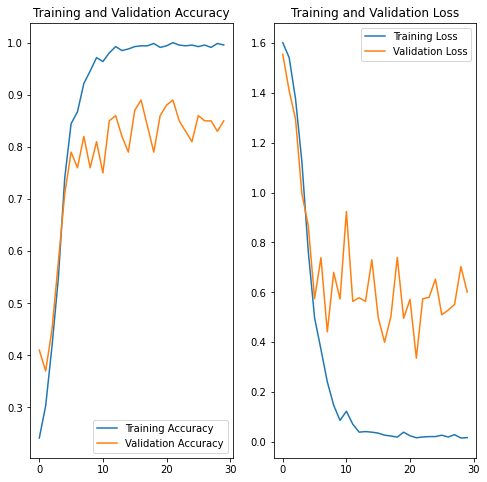

In [18]:
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## This train accuracy reached 100% which implies the model is also Overfitting
## So, we drop this model

### All the experiment details are recorded in the attached document